<a href="https://colab.research.google.com/github/agu3ro/Pytorch-DL/blob/main/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
%matplotlib inline
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
train_data = datasets.CIFAR10(root='/cnn_data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]))
test_data = datasets.CIFAR10(root='/cnn_data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False, num_workers=0)

In [ ]:
class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(3,6,3,1)
    self.conv2 = torch.nn.Conv2d(6,16,3,1)
    self.fc1 = torch.nn.Linear(16*6*6, 128)
    self.fc2 = torch.nn.Linear(128,84)
    self.fc3 = torch.nn.Linear(84,10)

  def forward(self,x):
    x = torch.nn.functional.relu(self.conv1(x))
    x = torch.nn.functional.max_pool2d(x,2,2)
    x = torch.nn.functional.relu(self.conv2(x))
    x = torch.nn.functional.max_pool2d(x,2,2)
    x = x.view(-1,16*6*6)
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = self.fc3(x)
    return torch.nn.functional.log_softmax(x, dim=1)

In [ ]:
model = Model()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
train_losses = []
train_corr = []
for i in range(5):
  trn_corr = 0
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()
    trn_corr+=batch_corr

    if b%600==0:
      print(f"Epoch: {i}, batch: {b}, loss:{loss}")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_losses.append(loss)
  train_corr.append(trn_corr)

Epoch: 0, batch: 600, loss:1.7530399560928345
Epoch: 0, batch: 1200, loss:1.3372374773025513
Epoch: 0, batch: 1800, loss:1.2139812707901
Epoch: 0, batch: 2400, loss:1.296354055404663
Epoch: 0, batch: 3000, loss:1.2719401121139526
Epoch: 0, batch: 3600, loss:1.1064012050628662
Epoch: 0, batch: 4200, loss:1.4866300821304321
Epoch: 0, batch: 4800, loss:0.5882225632667542
Epoch: 1, batch: 600, loss:1.5917177200317383
Epoch: 1, batch: 1200, loss:0.9822037816047668
Epoch: 1, batch: 1800, loss:1.2126948833465576
Epoch: 1, batch: 2400, loss:1.241491436958313
Epoch: 1, batch: 3000, loss:1.4944592714309692
Epoch: 1, batch: 3600, loss:1.280202031135559
Epoch: 1, batch: 4200, loss:1.7444982528686523
Epoch: 1, batch: 4800, loss:1.2423657178878784
Epoch: 2, batch: 600, loss:0.955278754234314
Epoch: 2, batch: 1200, loss:1.3235126733779907
Epoch: 2, batch: 1800, loss:0.9637511968612671
Epoch: 2, batch: 2400, loss:1.0418092012405396
Epoch: 2, batch: 3000, loss:0.44901713728904724
Epoch: 2, batch: 3600,

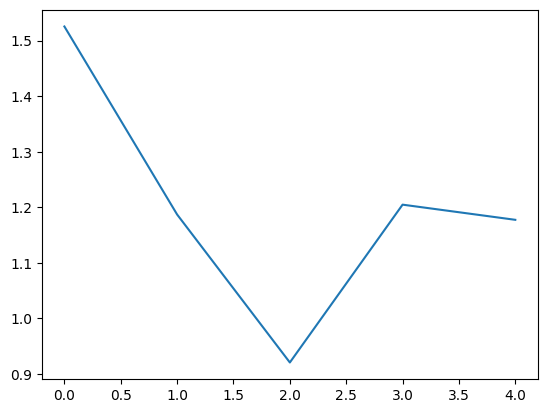

In [ ]:
plt.plot([t.item() for t in train_losses], label='train_losses')

In [ ]:
train_corr

[tensor(23366), tensor(28794), tensor(31153), tensor(32447), tensor(33754)]

In [ ]:
(train_corr[4]/50000).item()


0.6750800013542175